### 导入数据

In [1]:
%matplotlib inline
import os
import glob
import xgboost
import operator
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel,RFECV
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_predict,StratifiedKFold,train_test_split,cross_val_score,LeaveOneOut
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,plot_confusion_matrix,auc,roc_auc_score,roc_curve,plot_roc_curve,ConfusionMatrixDisplay,mean_squared_error
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

#导入数据
df = pd.read_excel(r"F:\Desktop\Kidney\51例\vp.xlsx")
target=df.iloc[:,1:2]
features=df.iloc[:,2:102]
features_names=list(features.columns)

#不标准化数据
X_data_2 = features
y_data_2 = target

#标准化所有数据
scaler = StandardScaler()#scaler = MinMaxScaler()#scaler = RobustScaler()
X_data_1 = pd.DataFrame(scaler.fit_transform(features),columns=features_names)
y_data_1 = target

### 随机森林+RFECV

In [87]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

scaler = StandardScaler()
sm = SMOTE(random_state=83)
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
estimator = ([("stand",scaler),("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_2, y_data_2)
    
names = list(X_data_2.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_features = X_data_2.loc[:, names]

选择的特征子集为： ['original_firstorder_InterquartileRange', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Skewness', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis']
RFECV 选择出的特征个数 ： 6
Grid_Score: 0.620833


In [59]:
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [1,2,3,4,5,6,7,8,9],
          'clf__min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10,11],
          'clf__min_samples_split' : [1,2,3,4,5,6,7,8],
          'clf__n_estimators': [7,8,9,10,11]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_2)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)
select_features = X_data_2.loc[:, names]

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 8}
模型最佳AUC为： 0.88125


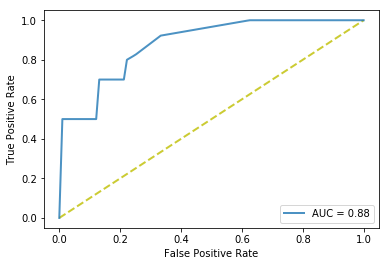

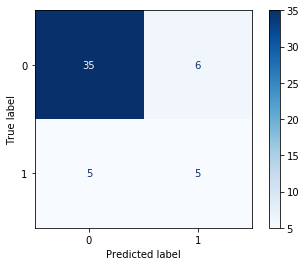

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR)
Random forest,0.79±0.08,0.88±0.1,0.5±0.32,0.86±0.04


In [89]:
best_clf=RandomForestClassifier(criterion='gini', max_depth=4, max_features='auto', min_samples_leaf=1,
                                min_samples_split=3, n_estimators=8, random_state=1,n_jobs=-1,class_weight="balanced")
#best_clf=RandomForestClassifier(criterion='gini', max_depth=3, max_features='auto', min_samples_leaf=7,
#                                min_samples_split=4, n_estimators=10, random_state=1,n_jobs=-1)
cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_2): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=83)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['Random forest'])
result

### SVM+RFECV

In [171]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

sm = SMOTE(random_state=83)
clf = SVC(kernel = "linear",random_state=1,class_weight="balanced",probability=True)
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_1, y_data_1)

names = list(X_data_1.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))

#网格搜索最佳参数
select_features = X_data_1.loc[:, names]
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','ACCURACY':'accuracy','F1':'f1'}
params = {'clf__kernel' : ['linear'],
          'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

选择的特征子集为： ['original_firstorder_InterquartileRange', 'original_firstorder_Mean', 'original_firstorder_Minimum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Imc1', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_shape_Elongation', 'original_shape_Sphericity']
RFECV 选择出的特征个数 ： 14
Grid_Score: 0.536111
模型最佳参数为： {'clf__C': 0.7, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.775


[0.9444444444444444, 0.875, 0.625, 0.875, 0.875]
[array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.

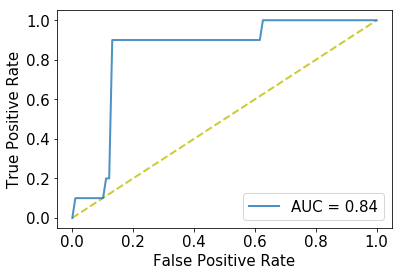

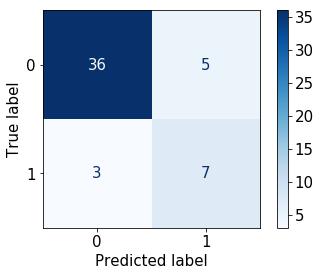

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR)
SVM,0.84±0.08,0.84±0.11,0.7±0.4,0.88±0.08


In [186]:
best_clf = grid_search.best_estimator_

cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_1): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
    
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    proba = best_clf.predict_proba(X_test)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
    
print(aucs)
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['SVM'])
result

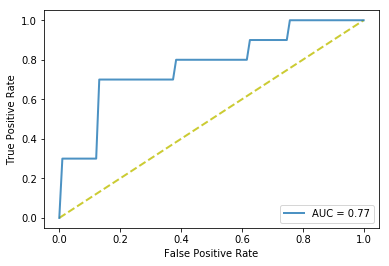

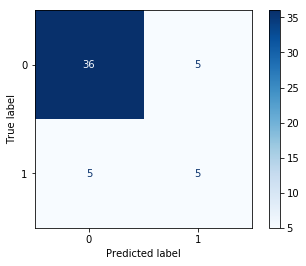

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR)
SVM,0.8±0.09,0.78±0.25,0.5±0.45,0.88±0.08


In [79]:
best_clf=SVC(kernel = "linear",C=0.7,random_state=1,probability=True)

cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_1): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=83)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['SVM'])
result

### 逻辑回归+RFECV

In [25]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

sm = SMOTE(random_state=83)
clf =  LogisticRegression()
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_1, y_data_1)

names = list(X_data_1.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))

#网格搜索最佳参数
select_features = X_data_1.loc[:, names]
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__penalty': ['l2','l1'],
          'clf__C':  [50,100,150],
         'clf__solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

选择的特征子集为： ['original_glszm_ZoneEntropy', 'original_shape_Elongation', 'original_shape_Sphericity']
RFECV 选择出的特征个数 ： 3
Grid_Score: 0.486111
模型最佳参数为： {'clf__C': 50, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}
模型最佳AUC为： 0.7541666666666667


In [30]:
#网格搜索最佳参数
select_features = X_data_1.loc[:, names]
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__penalty': ['l2','l1'],
          'clf__C':  [20,21,22,23,24,25],
         'clf__solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

模型最佳参数为： {'clf__C': 21, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
模型最佳AUC为： 0.7541666666666667


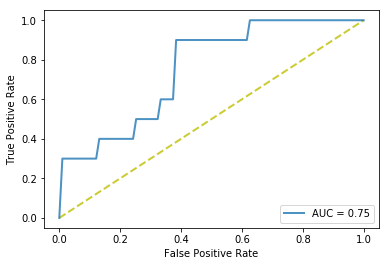

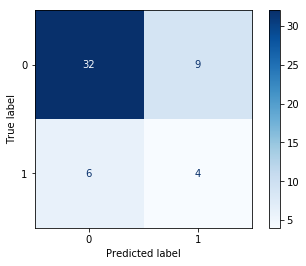

,Accuracy,Auc,F1-score,Precision,Sensitivity(TPR),Specificity(TNR)
SVM,0.705455,0.754167,0.34,0.3,0.4,0.780556


In [31]:
best_clf=LogisticRegression(C=21,penalty='l1',solver='liblinear')

cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_1): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=83)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': [np.mean(acc)], 
                'Auc': [np.mean(aucs)], 
                'Sensitivity(TPR)': [np.mean(sen)], 
                'Specificity(TNR)': [np.mean(spe)],
                'Precision': [np.mean(pre)],
                'F1-score': [np.mean(f1)]
                }
    
result = pd.DataFrame(result_dict, index=['LR'])
result

### XGBoost+RFECV

In [80]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

scaler = StandardScaler()
sm = SMOTE(random_state=83)
clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
xgboost.set_config(verbosity=0)  
estimator = ([("stand",scaler),("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)
    
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_2, y_data_2)
    
names = list(X_data_2.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_features = X_data_2.loc[:, names]

选择的特征子集为： ['original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Skewness', 'original_gldm_DependenceVariance', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_shape_Flatness']
RFECV 选择出的特征个数 ： 11
Grid_Score: 0.488889


In [86]:
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__colsample_bytree' : [0.1,0.2],
          'clf__gamma' : [0.1,0.2],
          'clf__learning_rate' : [0.01,0.02],
          'clf__max_depth' : [3,4,5],
          'clf__min_child_weight' : [1,2,3],
          'clf__n_estimators' : [3,4,5],          
          'clf__reg_alpha' : [1,2],
          'clf__reg_lambda' : [1,2,3],
          'clf__subsample' : [0.7,0.8,0.9]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_2)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_child_weight': 2, 'clf__n_estimators': 4, 'clf__reg_alpha': 1, 'clf__reg_lambda': 2, 'clf__subsample': 0.9}
模型最佳AUC为： 0.8652777777777778


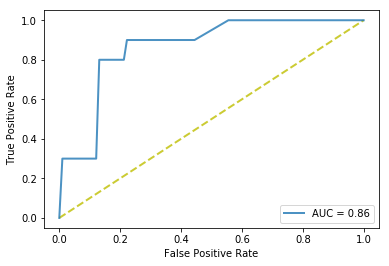

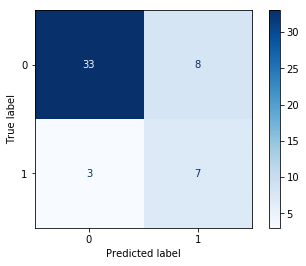

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR)
XGBoost,0.79±0.03,0.87±0.12,0.7±0.24,0.81±0.06


In [85]:
best_clf=xgboost.XGBClassifier(colsample_bytree=0.1, gamma=0.1, learning_rate=0.01, max_depth=4, 
                               min_child_weight=2, n_estimators=4, reg_alpha=1, reg_lambda=2, 
                               subsample=0.9, random_state=1,n_jobs=-1)
cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_2): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=83)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
std_acc = np.std(acc) 
std_auc = np.std(aucs)   
std_sen = np.std(sen) 
std_spe = np.std(spe) 
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['XGBoost'])
result

### 可视化特征

<function matplotlib.pyplot.show>

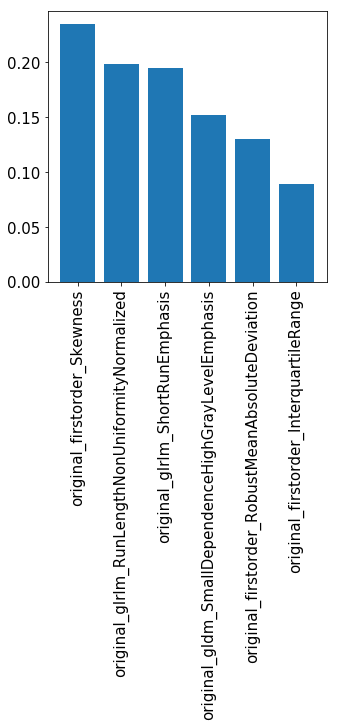

In [119]:
import matplotlib.pyplot as plt
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced") 
clf.fit(select_features,y_data_2)
importances=clf.feature_importances_
indices=np.argsort(importances)[::-1]
features_names = list(X_data_2.columns[rfecv.support_])
names=[features_names[i] for i in indices]
matplotlib.rcParams.update({'font.size': 15})
#特征重要性排序图
plt.figure(figsize=(5,5))
plt.title=("Feature Importance")
plt.bar(range(select_features.shape[1]),importances[indices])
plt.xticks(range(select_features.shape[1]),names,rotation=90)
plt.show

TypeError: 'list' object is not callable

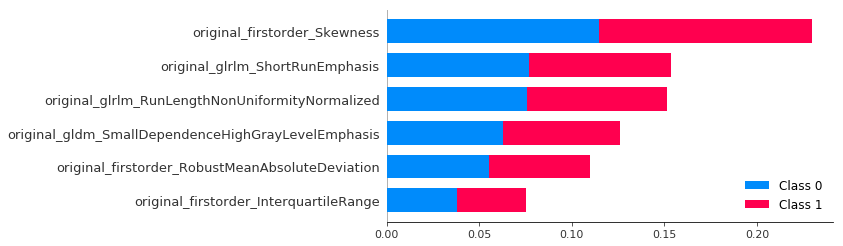

In [161]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(select_features)
shap.summary_plot(shap_values, select_features)

### 不同分类器设置不同随机种子并取均值

#### SVM分类器

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 12
选择的特征子集为： ['original_firstorder_InterquartileRange', 'original_firstorder_Mean', 'original_glcm_Contrast', 'original_glcm_Imc1', 'original_glrlm_RunEntropy', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_shape_Elongation', 'original_shape_Sphericity']
Grid_Score: 0.534722
模型最佳参数为： {'clf__C': 0.6, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.8388888888888889
第 2 次循环
随机种子数为： 10
RFECV 选择出的特征个数 ： 19
选择的特征子集为： ['original_firstorder_InterquartileRange', 'original_firstorder_Mean', 'original_firstorder_Minimum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_DifferenceVariance', 'original_glcm_Imc1', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunEmphasis', 'original_glr

模型最佳参数为： {'clf__C': 0.6, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.7555555555555555
第 12 次循环
随机种子数为： 110
RFECV 选择出的特征个数 ： 14
选择的特征子集为： ['original_firstorder_Minimum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_DifferenceVariance', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_shape_Elongation', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio']
Grid_Score: 0.559722
模型最佳参数为： {'clf__C': 20, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.8138888888888889
第 13 次循环
随机种子数为： 120
RFECV 选择出的特征个数 ： 18
选择的特征子集为： ['original_firstorder_Mean', 'original_firstorder_Minimum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_DifferenceVariance', 'original_glcm_Imc1

模型最佳参数为： {'clf__C': 2, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.7291666666666667
第 23 次循环
随机种子数为： 220
RFECV 选择出的特征个数 ： 18
选择的特征子集为： ['original_firstorder_Mean', 'original_firstorder_Minimum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_DifferenceVariance', 'original_glcm_Imc1', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_shape_Elongation', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio']
Grid_Score: 0.511111
模型最佳参数为： {'clf__C': 2, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.85
第 24 次循环
随机种子数为： 240
RFECV 选择出的特征个数 ： 15
选择的特征子集为： ['original_firstorder_InterquartileRange', 'original_firstorder_Mean', 'origina

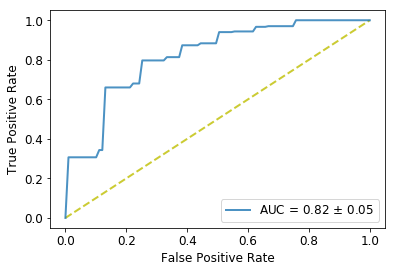

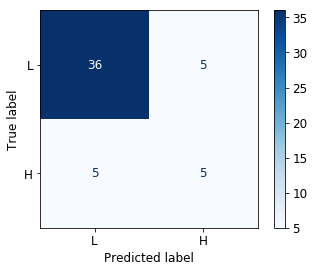

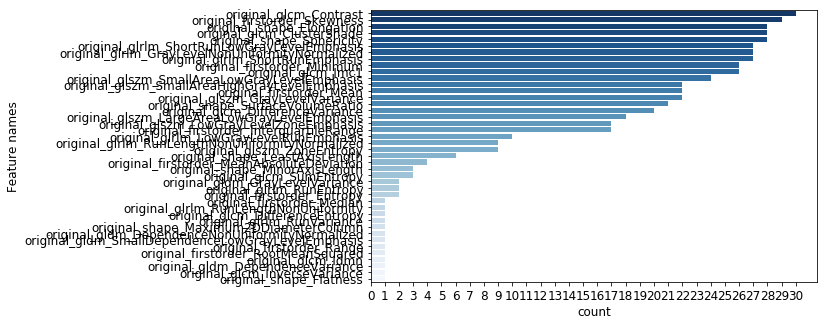

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
SVM,0.8±0.04,0.82±0.05,0.43±0.1,0.5±0.12,0.87±0.03


In [3]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

svm_cons = 0
svm_accs = []
svm_aucs = [] 
svm_sens = []
svm_spes = []
svm_f1s = []
svm_tprs = []
n=0
svm_feature_set = []
mean_fpr = np.linspace(0, 1, 100) 
a=list(range(0,230,10))
a.extend(list(range(240,310,10)))
for i in a: 
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = SVC(kernel = "linear",random_state=1,class_weight="balanced",probability=True)
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #svmECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    svm_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__kernel' : ['linear'],
              'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,4,6,8,10,20]}    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score,
                               n_jobs=-1,
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    svm_tprs.append(np.mean(tpr_, axis=0))
    svm_accs.append(np.mean(acc))
    svm_aucs.append(np.mean(auc_))  
    svm_sens.append(np.mean(sen))
    svm_spes.append(np.mean(spe))
    svm_f1s.append(np.mean(f1))
    svm_cons=svm_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
svm_mean_tpr = np.mean(svm_tprs, axis=0)
svm_mean_tpr[-1] = 1.0
svm_mean_auc = auc(mean_fpr, svm_mean_tpr)
svm_std_auc = np.std(svm_aucs)
plt.plot(mean_fpr, svm_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (svm_mean_auc,svm_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(svm_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
svm_select_names = pd.concat([pd.DataFrame(svm_feature_set[i],columns=['Feature names']) for i in range(n)])
svm_result=pd.DataFrame(pd.value_counts(svm_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=svm_select_names, order=svm_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
svm_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(svm_accs),2)),str(round(np.std(svm_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(svm_aucs),2)),str(round(np.std(svm_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(svm_sens),2)),str(round(np.std(svm_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(svm_spes),2)),str(round(np.std(svm_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(svm_f1s),2)),str(round(np.std(svm_f1s),2))])] 
                }

result_svm = pd.DataFrame(svm_result_dict, index=['SVM'])
result_svm

In [7]:
svm_mean_tpr=[0.        , 0.30666667, 0.30666667, 0.30666667, 0.30666667,
       0.30666667, 0.30666667, 0.30666667, 0.30666667, 0.30666667,
       0.30666667, 0.34333333, 0.34333333, 0.66      , 0.66      ,
       0.66      , 0.66      , 0.66      , 0.66      , 0.66      ,
       0.66      , 0.66      , 0.68      , 0.68      , 0.68      ,
       0.79666667, 0.79666667, 0.79666667, 0.79666667, 0.79666667,
       0.79666667, 0.79666667, 0.79666667, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.87333333, 0.87333333,
       0.87333333, 0.87333333, 0.87333333, 0.87333333, 0.88333333,
       0.88333333, 0.88333333, 0.88333333, 0.88333333, 0.88333333,
       0.94      , 0.94      , 0.94      , 0.94      , 0.94      ,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.97      , 0.97      , 0.97      , 0.97      ,
       0.97      , 0.97      , 0.97      , 0.97      , 0.97      ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]

In [8]:
svm_mean_auc=0.8193265993265992

In [9]:
svm_std_auc=0.05

In [17]:
svm_result

,Feature names
original_glcm_Contrast,30
original_firstorder_Skewness,29
original_shape_Elongation,28
original_shape_Sphericity,28
original_glcm_ClusterShade,28
original_glrlm_ShortRunEmphasis,27
original_glrlm_GrayLevelNonUniformityNormalized,27
original_glrlm_ShortRunLowGrayLevelEmphasis,27
original_firstorder_Minimum,26
original_glcm_Imc1,26


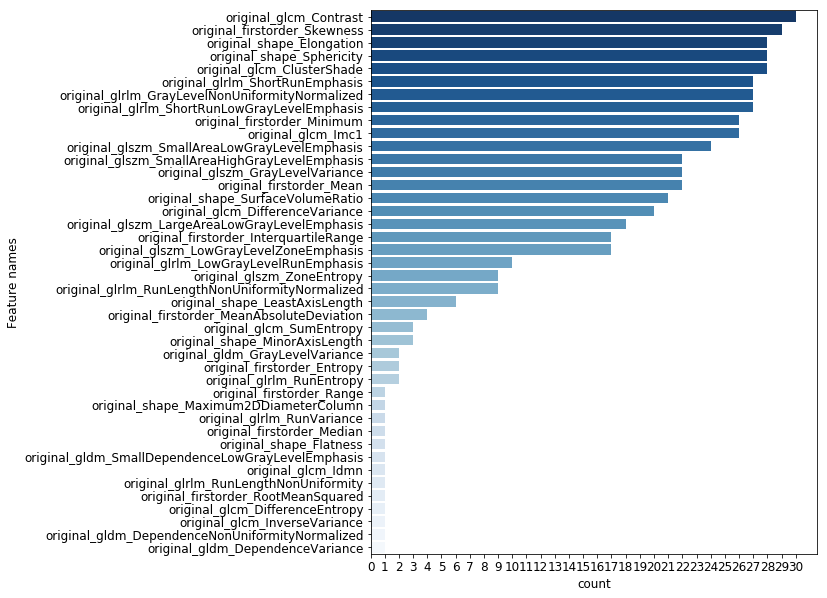

In [12]:
#特征频率图可视化
svm_select_names = pd.concat([pd.DataFrame(svm_feature_set[i],columns=['Feature names']) for i in range(n)])
svm_result=pd.DataFrame(pd.value_counts(svm_select_names['Feature names']))
plt.figure(figsize=(8, 10))
f = sns.countplot(y='Feature names',data=svm_select_names, order=svm_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#### 随机森林分类器

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 7
选择的特征子集为： ['original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Skewness', 'original_glcm_MaximumProbability', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelVariance']
Grid_Score: 0.716667
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 7, 'clf__n_estimators': 15}
模型最佳AUC为： 0.7819444444444444
第 2 次循环
随机种子数为： 10
RFECV 选择出的特征个数 ： 3
选择的特征子集为： ['original_firstorder_Skewness', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized']
Grid_Score: 0.725694
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 3, 'clf__n_estimators': 15}
模型最佳AUC为： 0.8583333333333334
第 3 次循环
随机种子数为： 20
RFECV 选择出的特征个数 ：

第 19 次循环
随机种子数为： 180
RFECV 选择出的特征个数 ： 3
选择的特征子集为： ['original_firstorder_Skewness', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis']
Grid_Score: 0.683333
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 3, 'clf__n_estimators': 12}
模型最佳AUC为： 0.7930555555555555
第 20 次循环
随机种子数为： 190
RFECV 选择出的特征个数 ： 3
选择的特征子集为： ['original_firstorder_Skewness', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis']
Grid_Score: 0.636111
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 3, 'clf__n_estimators': 12}
模型最佳AUC为： 0.7354166666666667
第 21 次循环
随机种子数为： 200
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_firstorder_Skewness']
Grid_Score: 0.663889
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 11, 'clf__m

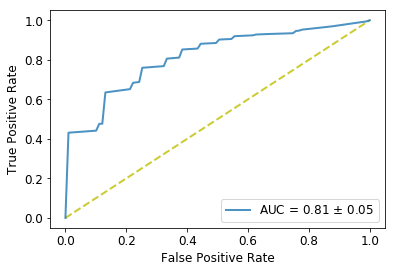

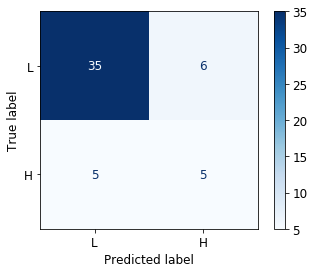

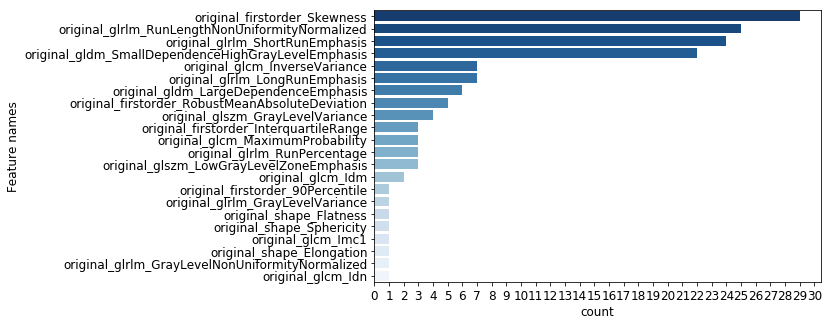

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
RF,0.78±0.03,0.82±0.05,0.45±0.08,0.51±0.09,0.85±0.05


In [2]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

rf_cons = 0
rf_accs = []
rf_aucs = [] 
rf_sens = []
rf_spes = []
rf_f1s = []
rf_tprs = []
n=0
rf_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,10):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #RFECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    rf_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [1,3,5,7,9],
          'clf__min_samples_leaf' : [2,4,6,8,10,11],
          'clf__min_samples_split' : [1,3,5,7,8],
          'clf__n_estimators': [5,7,9,11,12,15]}    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    rf_tprs.append(np.mean(tpr_, axis=0))
    rf_accs.append(np.mean(acc))
    rf_aucs.append(np.mean(auc_))  
    rf_sens.append(np.mean(sen))
    rf_spes.append(np.mean(spe))
    rf_f1s.append(np.mean(f1))
    rf_cons=rf_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
plt.plot(mean_fpr, rf_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (rf_mean_auc,rf_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(rf_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
rf_select_names = pd.concat([pd.DataFrame(rf_feature_set[i],columns=['Feature names']) for i in range(n)])
rf_result=pd.DataFrame(pd.value_counts(rf_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=rf_select_names, order=rf_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
rf_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(rf_accs),2)),str(round(np.std(rf_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(rf_aucs),2)),str(round(np.std(rf_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(rf_sens),2)),str(round(np.std(rf_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(rf_spes),2)),str(round(np.std(rf_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(rf_f1s),2)),str(round(np.std(rf_f1s),2))])] 
                }

rf_result = pd.DataFrame(rf_result_dict, index=['RF'])
rf_result

In [10]:
rf_mean_tpr=[0.        , 0.43114478, 0.43228956, 0.43343434, 0.43457912,
       0.43572391, 0.43686869, 0.43801347, 0.43915825, 0.44030303,
       0.44144781, 0.47592593, 0.47661616, 0.63484287, 0.6369248 ,
       0.63900673, 0.64108866, 0.64317059, 0.64525253, 0.64733446,
       0.64941639, 0.65149832, 0.68358025, 0.68566218, 0.68774411,
       0.75960157, 0.76078563, 0.7619697 , 0.76315376, 0.76433782,
       0.76552189, 0.76670595, 0.76789001, 0.80574074, 0.80707632,
       0.8084119 , 0.80974747, 0.81108305, 0.8520651 , 0.85299663,
       0.85392817, 0.85485971, 0.85579125, 0.85672278, 0.88098765,
       0.88176768, 0.8825477 , 0.88332772, 0.88410774, 0.88488777,
       0.90231201, 0.90304714, 0.90378227, 0.9045174 , 0.90525253,
       0.91932099, 0.92005612, 0.92079125, 0.92152637, 0.9222615 ,
       0.92299663, 0.92373176, 0.927789  , 0.92843434, 0.92907969,
       0.92972503, 0.93037037, 0.9308642 , 0.93135802, 0.93185185,
       0.93234568, 0.93283951, 0.93333333, 0.93382716, 0.93432099,
       0.94572391, 0.94742985, 0.95246914, 0.95417508, 0.95588103,
       0.95758698, 0.95929293, 0.96099888, 0.96270483, 0.96441077,
       0.96611672, 0.96782267, 0.96973064, 0.97197531, 0.97421998,
       0.97646465, 0.97870932, 0.98095398, 0.98319865, 0.98544332,
       0.98768799, 0.98993266, 0.99217733, 0.994422  , 1.        ]

In [11]:
rf_mean_auc=0.8140637009828926

In [12]:
rf_std_auc=0.04528452290135442

In [1]:
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
plt.plot(mean_fpr, rf_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (rf_mean_auc,rf_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(rf_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
rf_select_names = pd.concat([pd.DataFrame(rf_feature_set[i],columns=['Feature names']) for i in range(n)])
rf_result=pd.DataFrame(pd.value_counts(rf_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=rf_select_names, order=rf_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
rf_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(rf_accs),2)),str(round(np.std(rf_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(rf_aucs),2)),str(round(np.std(rf_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(rf_sens),2)),str(round(np.std(rf_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(rf_spes),2)),str(round(np.std(rf_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(rf_f1s),2)),str(round(np.std(rf_f1s),2))])] 
                }

result_rf = pd.DataFrame(rf_result_dict, index=['RF'])
result_rf

NameError: name 'matplotlib' is not defined

In [20]:
rf_result

,Feature names
original_firstorder_Skewness,29
original_glrlm_RunLengthNonUniformityNormalized,25
original_glrlm_ShortRunEmphasis,24
original_gldm_SmallDependenceHighGrayLevelEmphasis,22
original_glrlm_LongRunEmphasis,7
original_glcm_InverseVariance,7
original_gldm_LargeDependenceEmphasis,6
original_firstorder_RobustMeanAbsoluteDeviation,5
original_glszm_GrayLevelVariance,4
original_glcm_MaximumProbability,3


#### XGBoost

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 4
选择的特征子集为： ['original_firstorder_Skewness', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_shape_Flatness']
Grid_Score: 0.546528
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.6, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 8, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 1}
模型最佳AUC为： 0.8555555555555555
第 2 次循环
随机种子数为： 10
RFECV 选择出的特征个数 ： 12
选择的特征子集为： ['original_firstorder_Skewness', 'original_glcm_Imc1', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_ZonePercentage', 'original_shape_Elongation', 'original_shape_Flatness']
Grid_Score: 0.48611

模型最佳参数为： {'clf__colsample_bytree': 0.7, 'clf__gamma': 0.4, 'clf__learning_rate': 0.07, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 8, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
模型最佳AUC为： 0.8166666666666668
第 15 次循环
随机种子数为： 140
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_firstorder_Skewness']
Grid_Score: 0.608333
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 1, 'clf__n_estimators': 4, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 0.2}
模型最佳AUC为： 0.820138888888889
第 16 次循环
随机种子数为： 150
RFECV 选择出的特征个数 ： 3
选择的特征子集为： ['original_firstorder_Skewness', 'original_glrlm_LongRunEmphasis', 'original_glrlm_ShortRunEmphasis']
Grid_Score: 0.558333
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 4, 'clf__reg_alpha': 3, 'clf__reg_lambda': 1, 'clf__subsa

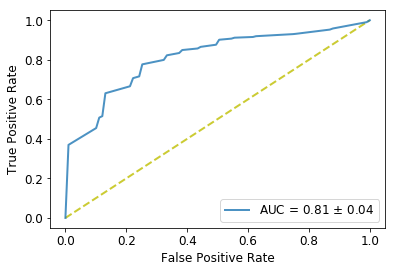

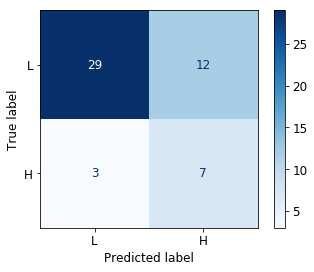

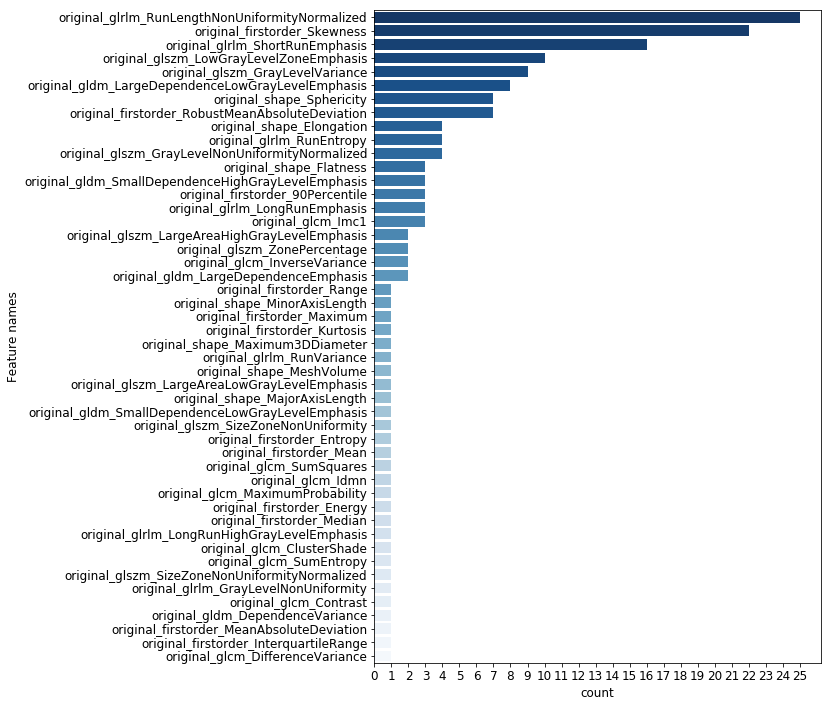

[0.         0.36945567 0.37891134 0.388367   0.39782267 0.40727834
 0.41673401 0.42618967 0.43564534 0.44510101 0.45455668 0.50734568
 0.51498316 0.63061167 0.63503479 0.63945791 0.64388103 0.64830415
 0.65272727 0.65715039 0.66157351 0.66599663 0.70708642 0.71156004
 0.71603367 0.77685971 0.78007632 0.78329293 0.78650954 0.78972615
 0.79294276 0.79615937 0.79937598 0.82259259 0.82550617 0.82841975
 0.83133333 0.83424691 0.84931538 0.85088215 0.85244893 0.85401571
 0.85558249 0.85714927 0.86538272 0.86755556 0.8697284  0.87190123
 0.87407407 0.87624691 0.90137149 0.90278114 0.9041908  0.90560045
 0.9070101  0.91175309 0.91235466 0.91295623 0.9135578  0.91415937
 0.91476094 0.91536251 0.91933109 0.92020202 0.92107295 0.92194388
 0.92281481 0.92368575 0.92455668 0.92542761 0.92629854 0.92716947
 0.9280404  0.92891134 0.92978227 0.93144781 0.93337823 0.93530864
 0.93723906 0.93916947 0.94109989 0.9430303  0.94496072 0.94689113
 0.94882155 0.95075196 0.95268238 0.9583165  0.96123457 0.9641

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
XGB,0.7±0.08,0.81±0.04,0.47±0.12,0.68±0.17,0.71±0.11


In [2]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

xgb_cons = 0
xgb_accs = []
xgb_aucs = [] 
xgb_sens = []
xgb_spes = []
xgb_f1s = []
xgb_tprs = []
n=0
xgb_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,10):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
    xgboost.set_config(verbosity=0) 
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #xgbECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    xgb_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__colsample_bytree' : [0.1,0.3,0.7,0.9],
              'clf__gamma' : [0.2,0.4,0.6,0.8],
              'clf__learning_rate' : [0.01,0.03,0.07,0.09],
              'clf__max_depth' : [2,4,8,10],
              'clf__min_child_weight' : [1,3,7,9],
              'clf__n_estimators' : [2,4,8,10],          
              'clf__reg_alpha' : [1,3,7,9],
              'clf__reg_lambda' : [1,3,7,9],
              'clf__subsample' : [0.2,0.4,0.8,1]}  
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1,
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    xgb_tprs.append(np.mean(tpr_, axis=0))
    xgb_accs.append(np.mean(acc))
    xgb_aucs.append(np.mean(auc_))  
    xgb_sens.append(np.mean(sen))
    xgb_spes.append(np.mean(spe))
    xgb_f1s.append(np.mean(f1))
    xgb_cons=xgb_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
xgb_mean_tpr = np.mean(xgb_tprs, axis=0)
xgb_mean_tpr[-1] = 1.0
xgb_mean_auc = auc(mean_fpr, xgb_mean_tpr)
xgb_std_auc = np.std(xgb_aucs)
plt.plot(mean_fpr, xgb_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (xgb_mean_auc,xgb_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(xgb_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
xgb_select_names = pd.concat([pd.DataFrame(xgb_feature_set[i],columns=['Feature names']) for i in range(n)])
xgb_result=pd.DataFrame(pd.value_counts(xgb_select_names['Feature names']))
plt.figure(figsize=(8, 12))
f = sns.countplot(y='Feature names',data=xgb_select_names, order=xgb_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(26))
plt.show()

#模型结果
xgb_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(xgb_accs),2)),str(round(np.std(xgb_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(xgb_aucs),2)),str(round(np.std(xgb_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(xgb_sens),2)),str(round(np.std(xgb_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(xgb_spes),2)),str(round(np.std(xgb_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(xgb_f1s),2)),str(round(np.std(xgb_f1s),2))])] 
                }
print(xgb_mean_tpr)
print(xgb_mean_auc)
print(xgb_std_auc)
result_xgb = pd.DataFrame(xgb_result_dict, index=['XGB'])
result_xgb

In [4]:
xgb_mean_tpr

array([0.        , 0.36945567, 0.37891134, 0.388367  , 0.39782267,
       0.40727834, 0.41673401, 0.42618967, 0.43564534, 0.44510101,
       0.45455668, 0.50734568, 0.51498316, 0.63061167, 0.63503479,
       0.63945791, 0.64388103, 0.64830415, 0.65272727, 0.65715039,
       0.66157351, 0.66599663, 0.70708642, 0.71156004, 0.71603367,
       0.77685971, 0.78007632, 0.78329293, 0.78650954, 0.78972615,
       0.79294276, 0.79615937, 0.79937598, 0.82259259, 0.82550617,
       0.82841975, 0.83133333, 0.83424691, 0.84931538, 0.85088215,
       0.85244893, 0.85401571, 0.85558249, 0.85714927, 0.86538272,
       0.86755556, 0.8697284 , 0.87190123, 0.87407407, 0.87624691,
       0.90137149, 0.90278114, 0.9041908 , 0.90560045, 0.9070101 ,
       0.91175309, 0.91235466, 0.91295623, 0.9135578 , 0.91415937,
       0.91476094, 0.91536251, 0.91933109, 0.92020202, 0.92107295,
       0.92194388, 0.92281481, 0.92368575, 0.92455668, 0.92542761,
       0.92629854, 0.92716947, 0.9280404 , 0.92891134, 0.92978

In [5]:
xgb_mean_auc

0.811468682334002

In [6]:
xgb_std_auc

0.042722477081870776

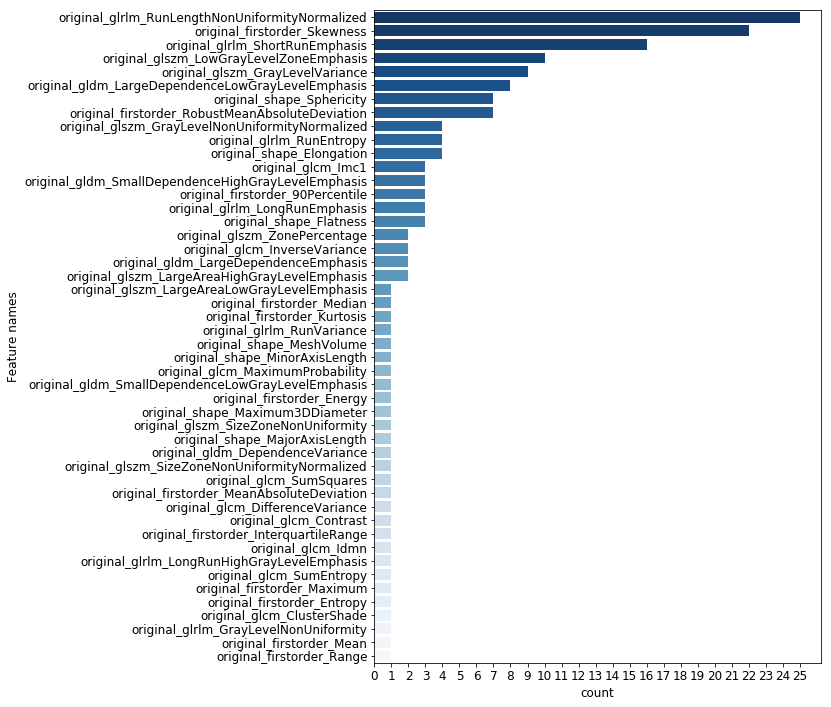

In [6]:
#特征频率图可视化
xgb_select_names = pd.concat([pd.DataFrame(xgb_feature_set[i],columns=['Feature names']) for i in range(n)])
xgb_result=pd.DataFrame(pd.value_counts(xgb_select_names['Feature names']))
plt.figure(figsize=(8, 12))
f = sns.countplot(y='Feature names',data=xgb_select_names, order=xgb_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(26))
plt.show()

In [22]:
xgb_result

,Feature names
original_glrlm_RunLengthNonUniformityNormalized,25
original_firstorder_Skewness,22
original_glrlm_ShortRunEmphasis,16
original_glszm_LowGrayLevelZoneEmphasis,10
original_glszm_GrayLevelVariance,9
original_gldm_LargeDependenceLowGrayLevelEmphasis,8
original_shape_Sphericity,7
original_firstorder_RobustMeanAbsoluteDeviation,7
original_glszm_GrayLevelNonUniformityNormalized,4
original_glrlm_RunEntropy,4


In [ ]:
sns.choose_colorbrewer_palette('sequential')

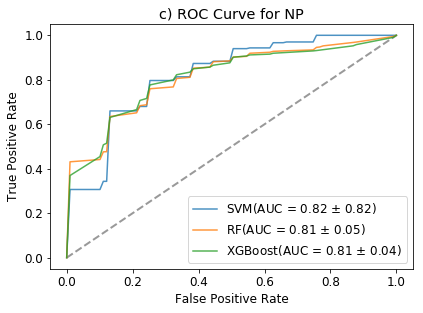

In [15]:
fig, ax = plt.subplots(figsize=(6.5,4.5))
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2,color='grey', 
         alpha=.8)

svm_mean_tpr[-1] = 1.0
#mean_auc_cmp = auc(mean_fpr, svm_mean_tpr)
ax.plot(mean_fpr, svm_mean_tpr, label=r'SVM(AUC = %0.2f $\pm$ %0.2f)'% (svm_mean_auc,svm_std_auc),lw=1.5, alpha=.8)

rf_mean_tpr[-1] = 1.0
#rf_mean_tpr = auc(mean_fpr, rf_mean_tpr)
ax.plot(mean_fpr, rf_mean_tpr, label=r'RF(AUC = %0.2f $\pm$ %0.2f)'% (rf_mean_auc,rf_std_auc),lw=1.5, alpha=.8)

xgb_mean_tpr[-1] = 1.0
#xgb_mean_auc = auc(mean_fpr, xgb_mean_auc)
ax.plot(mean_fpr, xgb_mean_tpr, label=r'XGBoost(AUC = %0.2f $\pm$ %0.2f)'% (xgb_mean_auc,xgb_std_auc),lw=1.5, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="c) ROC Curve for NP")
ax.legend(loc="lower right")

plt.show()